<a href="https://colab.research.google.com/github/ekat92/Book-Project-Econometrics-and-ML/blob/alpha_rnns/alpha_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Alpha_RNNs-QCBMPX-bondfund
# Author: Chris Zhu
# Version: 1.1 (17.12.2020)
# License: MIT
# Email: yzhu22@colby.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 2.2 Keras 2.3.1

## Overview
This notebook provides a toy example for $\alpha$-RNNs network to predict share price of one of the retirement pension funds, CREF Bond Market Account (QCBMPX). 

In [ ]:
#Only needed if the notebook is being run on Google Golab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
path = '/content/drive/My Drive/Book-Project-Econometrics-and-ML' # set the path to location of the data file QCBMPX_data.csv
sys.path.append(path)

In [ ]:
# only needed if the version is not compatible
# downgrade Tensorflow and Keras version 
# !pip install tensorflow==2.2.0
# !pip install q keras==2.3.1

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import statsmodels.api as sm
import os

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Layer, LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.regularizers import l1,l2
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.layers import Layer,RNN
from keras import backend as K
from keras import layers
import keras.layers
import tensorflow.keras as keras 
from keras.legacy import interfaces
from keras import *
# Custom classes for alpha-RNNs and alpha_t-RNNs
# Custom classes for alpha-RNNs and alpha_t-RNNs
from alphaRNN import *
from alphatRNN import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
%matplotlib inline

## Sample Data 


*   We will focus on CREF Bond Market Account (R2) (QCBMPX) fund. For additional information of the fund, please refer to the following link: https://www.tiaa.org/public/tcm/colby/investment-performance/investment/profile?ticker=268585732. 
*   We will first test stationality using an Augmented Dickey-Fuller test. Then, we will determine the number of lagged data to include by looking at partial auto-correlation.  In addition, we will scale and divide data into training and testing sets. In the end, we will compare results for $\alpha$-RNN, simple RNN, and $\alpha_t$-RNN. 



In [ ]:
# selecting data; we use close price as our data here. 
df = pd.read_csv(path + '/QCBMPX_data.csv', index_col=[0])
df = df["Close"]
df.head()

## RNN Regression 

### Stationary Test

In [ ]:
df=df.fillna(method="backfill")
adf, p, usedlag, nobs, cvs,aic=sm.tsa.stattools.adfuller(df.values)

In [ ]:
print(adf,p, nobs, cvs)

-1.6602153683642042 0.45171840651174583 243 {'1%': -3.4575505077947746, '5%': -2.8735087323013526, '10%': -2.573148434859185}


Here we accept the null as the p-value is larger than 0.01, thus we can not reject the test at the 99% confidence level. This suggests that the time series is non-stationary.

## Autoregressive Model Identification: The partial auto-correlation
determine number of lags to include

In [ ]:
pacf=sm.tsa.stattools.pacf(df, nlags=30)

In [ ]:
n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(df)))==False)[0][0] -1

In [ ]:
print(n_steps)

1


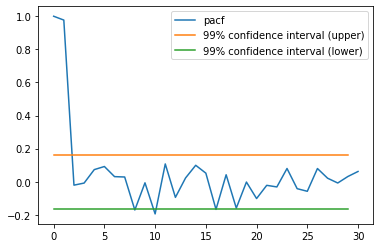

In [ ]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(len(df))]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(len(df))]*30, label='99% confidence interval (lower)')
plt.legend()

### Train/Test Data Split 
### Include lagged data

In [ ]:
train_weight = 0.8
split = int(len(df)*train_weight)
df_train = df.iloc[:split]

In [ ]:
mu = np.float(df_train.mean())
sigma = np.float(df_train.std())

In [ ]:
df_train = df_train.apply(lambda x: (x - mu) / sigma)

In [ ]:
df_test = df.iloc[split:]
df_test = df.apply(lambda x: (x - mu) / sigma).iloc[split:]

In [ ]:
def get_lagged_features(value, n_steps, n_steps_ahead):
    """
    value: feature value to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [ ]:
n_steps_ahead=1

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps, n_steps_ahead).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, ].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, ].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [ ]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)


(201, 1, 1) (201, 1, 1) (50, 1, 1) (50, 1, 1)


In [ ]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]
time_size = y_train_reg.shape[1]

In [ ]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, ].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [ ]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, ].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

## Define Models

In [ ]:
def AlphatRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def AlphaRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
max_epoches=2000
batch_size=1000

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)


In [ ]:
params = {'rnn': {'model':'', 'function':SimpleRNN_, 'l1_reg':0.0, 'H':20, 'color': 'blue', 'label':'RNN'}, 
          'alpharnn': {'model':'', 'function':AlphaRNN_,'l1_reg':0.0, 'H':10,'color': 'green', 'label': '$\\alpha$-RNN' }, 
          'alphatrnn': {'model':'', 'function':AlphatRNN_,'l1_reg':0.0, 'H':5, 'color': 'cyan', 'label': '$\\alpha_t$-RNN'}
         }

In [ ]:
cross_val=False # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [5,10,20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg[:30000],y_train_reg[:30000],callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

In [ ]:
for key in params.keys():
    tf.random.set_seed(0)
    model=params[key]['function'](params[key]['H'],params[key]['l1_reg'])
    model.fit(x_train_reg,y_train_reg,epochs=max_epoches, batch_size=batch_size,callbacks=[es],shuffle=False)
    params[key]['model']=model

In [ ]:
# optionally save the fitted model
# for key in params.keys():
#   params[key]['model'].save(key + '.hdf5', overwrite=True)  # creates a HDF5 file

In [ ]:
# optionally load the fitted model
# for key in params.keys():
#   params[key]['model']=load_model(key + '.hdf5')

In [ ]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))
model = params['alpharnn']['model']
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    if name =='alpha_rnn_1/alpha:0':
      print("alpha= " + str(sigmoid(weight)))

alpha= [0.6245412]


In [ ]:
for key in params.keys():
  model=params[key]['model']
  model.summary()
    
  params[key]['MSE_train']= mean_squared_error(df_train[n_steps+n_steps_ahead-1:],model.predict(x_train_reg, verbose=1))
  params[key]['predict'] = model.predict(x_test_reg, verbose=1) 
  params[key]['MSE_test']= mean_squared_error(df_test[n_steps+n_steps_ahead-1:],params[key]['predict'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20)                440       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
50/50 [==============================] - 0s 270us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alpha_rnn_1 (AlphaRNN)       (None, 10)                121       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 132
Trainable params: 132
Non-trainable params: 0
_______________________________________________

rnn
alpharnn
alphatrnn


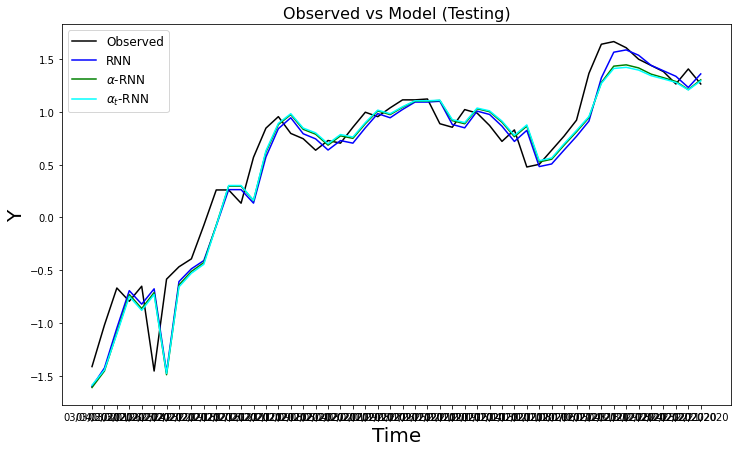

In [ ]:
fig = plt.figure(figsize=(12,7))
upper = 2000
plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[n_steps+n_steps_ahead-1:upper], color="black", label="Observed")

for key in params.keys():
  print(key)
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'])
plt.legend(loc="best", fontsize=12)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title('Observed vs Model (Testing)', fontsize=16)

plt.show()   

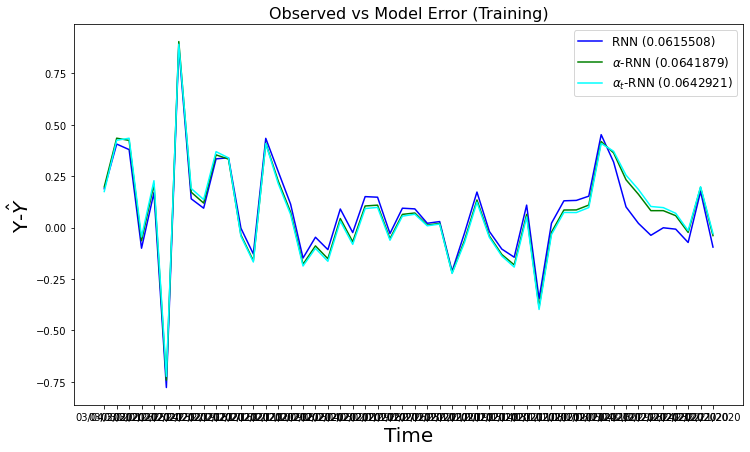

In [ ]:
fig = plt.figure(figsize=(12,7))

for key in params.keys():
   plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[n_steps+n_steps_ahead-1:upper]-params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'] + " (" +  str(round(params[key]['MSE_test'],7)) +")")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y-$\hat{Y}$', fontsize=20)

plt.show()